## Image-to-Image Translation with CycleGAN (PyTorch)

This repository provides a clean and practical implementation of **CycleGAN-based image-to-image translation**, built on top of the well-established [pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) codebase. Rather than re-implementing core architectures, the focus is on **reproducibility, clarity, and structured experimentation**, leveraging pretrained models and standardized datasets.

The workflow targets **unpaired image translation**, where corresponding image pairs across domains are not required. CycleGAN learns bidirectional mappings between two visual domains using cycle-consistency constraints, making it well suited for cross-domain medical imaging and visual style transfer tasks.

### 📦 Dataset Used

The experiments use the **Brain CT-to-MRI** dataset from Kaggle  
([CT-to-MRI CGAN Dataset](https://www.kaggle.com/datasets/darren2020/ct-to-mri-cgan)), which contains unpaired 2D brain images from two imaging modalities:

- **Domain A**: CT scans  
- **Domain B**: MRI scans  

This dataset is commonly used to study cross-modality image translation in medical imaging, where paired acquisitions are difficult or impossible to obtain. The goal is to learn a realistic mapping between CT and MRI appearances while preserving anatomical structure.

The dataset follows the standard CycleGAN directory structure:

- `trainA/`, `trainB/`: Unpaired training images from each modality  
- `testA/`, `testB/`: Unpaired test images for inference and evaluation  

This structure enables training and evaluation in both translation directions (CT → MRI and MRI → CT) using the same pipeline.


### 📥 Downloading and Extracting the CT-to-MRI Dataset

Downloads the **CT-to-MRI CGAN** dataset directly from Kaggle using its API endpoint, saves the compressed archive locally, and extracts its contents into the working dataset directory. After extraction, the zip file is removed to conserve storage. This prepares the dataset in the expected folder structure for CycleGAN training and inference.

In [1]:
OUTPUT_DIR = "./workdir/datasets"
DATA_LINK = "https://www.kaggle.com/api/v1/datasets/download/darren2020/ct-to-mri-cgan"

!curl -L -o {OUTPUT_DIR}/ct-to-mri-cgan.zip {DATA_LINK}
!unzip {OUTPUT_DIR}/ct-to-mri-cgan.zip -d {OUTPUT_DIR}/
!rm {OUTPUT_DIR}/ct-to-mri-cgan.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  185M  100  185M    0     0  17.6M      0  0:00:10  0:00:10 --:--:-- 21.0M


### 🏋️ Training CycleGAN for CT ↔ MRI Translation

Sets up the working environment and launches CycleGAN training on the **Brain CT-to-MRI** dataset. The training script is executed from the original `pytorch-CycleGAN-and-pix2pix` repository, using the standard CycleGAN model configuration.

Key aspects of this setup:
- The dataset root points to the CT/MRI image directories organized in CycleGAN format.
- Training is run for a fixed number of epochs followed by a decay phase to gradually reduce the learning rate.
- Model checkpoints are saved to a dedicated checkpoints directory for later inference or evaluation.
- Weights & Biases (`wandb`) logging is enabled to track training progress and losses.

This step learns bidirectional mappings between CT and MRI image domains without requiring paired samples.

```
WORK_DIR="./workdir"
CURR_DIR="${WORK_DIR}/cycle_gan/pytorch-CycleGAN-and-pix2pix"
cd "$CURR_DIR"

DATA_ROOT="${WORK_DIR}/datasets/brain_ct2mri/images"
CHKPTS_DIR="${WORK_DIR}/checkpoints"
NAME="brain_ct2mri"
MODEL="cycle_gan"
N_EPOCHS=2
N_EPOCHS_DECAY=2

python train.py \
  --dataroot "$DATA_ROOT" \
  --checkpoints_dir "$CHKPTS_DIR" \
  --name "$NAME" \
  --model "$MODEL" \
  --n_epochs "$N_EPOCHS" \
  --n_epochs_decay "$N_EPOCHS_DECAY" \
  --use_wandb
```

### 📊 Visualizing CycleGAN Training Losses from Log Files

Parses CycleGAN training logs and visualizes the evolution of key loss components across epochs. The function uses regular expressions to extract discriminator, generator, cycle-consistency, and identity losses for both domains (A and B), supporting one or multiple training runs within the same log file.

The extracted data are aggregated per epoch and plotted, where each subplot corresponds to a specific loss term (e.g., Generator A, Cycle Loss B).  This visualization is useful for diagnosing convergence behavior, imbalance between generators and discriminators, and the effect of different training configurations.

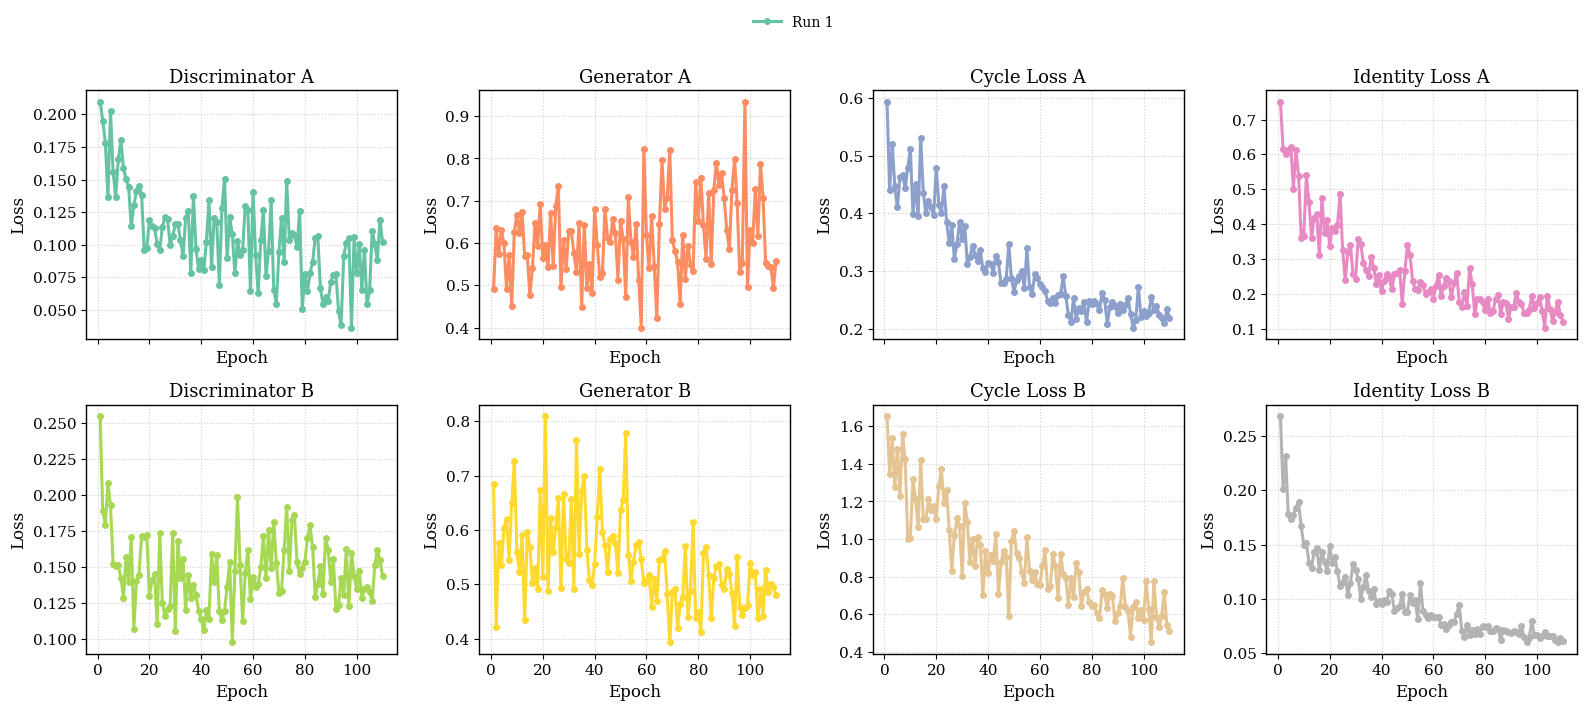

In [53]:
plot_learning_curves_from_log(log_file)

### 🔄 Running Inference and Visualizing CT ↔ MRI Translations

Configures and runs CycleGAN inference for the trained **Brain CT ↔ MRI** model in a selected translation direction (`ct_to_mri` or `mri_2_ct`). Depending on the chosen mode, the corresponding generator checkpoint (`G_A` or `G_B`) is copied to the expected filename so that the standard `test.py` script can be used without modification.

After inference, a random subset of test images is visualized in a **2 × N grid**, where:
- The top row shows the **real input images** from the source modality.
- The bottom row shows the **translated (fake) images** generated by the CycleGAN model in the target modality.

This setup provides a clear qualitative comparison of cross-modality translation performance and allows quick inspection of model behavior in both CT → MRI and MRI → CT directions.

In [ ]:
import matplotlib.pyplot as plt
import random
import os 

WORK_DIR = "./workdir"
DATA_ROOT = f"{WORK_DIR}/datasets/brain_ct2mri/images"
CHKPTS_DIR = f"{WORK_DIR}/checkpoints"
OUTPUT_DIR = f"{WORK_DIR}/outputs"
NAME = "brain_ct2mri"
MODEL = "test"
TEST_MODE = "ct_to_mri" 
TEST_NAME = "testA"

def plot_test_samples():
    images_list = sorted(os.listdir(os.path.join(DATA_ROOT, TEST_NAME)))
    indices = random.sample(range(len(images_list)), 8)

    fig, axes = plt.subplots(2, len(indices), figsize=(2 * len(indices), 4))
    for col, idx in enumerate(indices):
        image_name = os.path.splitext(images_list[idx])[0]
        img_real = plt.imread(os.path.join(OUTPUT_DIR, NAME, "test_latest", "images", f"{image_name}_real.png"))
        img_fake = plt.imread(os.path.join(OUTPUT_DIR, NAME, "test_latest", "images", f"{image_name}_fake.png"))

        axes[0, col].imshow(img_real)
        axes[0, col].set_title(f"Real-{TEST_MODE.split('_')[0].upper()} ({idx})", fontsize=12)
        axes[0, col].axis("off")

        axes[1, col].imshow(img_fake)
        axes[1, col].set_title(f"Fake-{TEST_MODE.split('_')[2].upper()} ({idx})", fontsize=12)
        axes[1, col].axis("off")

    axes[0, 0].set_ylabel("Real", fontsize=14)
    axes[1, 0].set_ylabel("Fake", fontsize=14)

    plt.tight_layout()
    plt.show()

Taking **CT input images** from the source modality and translate it to **fake MRI images** generated by the CycleGAN model:

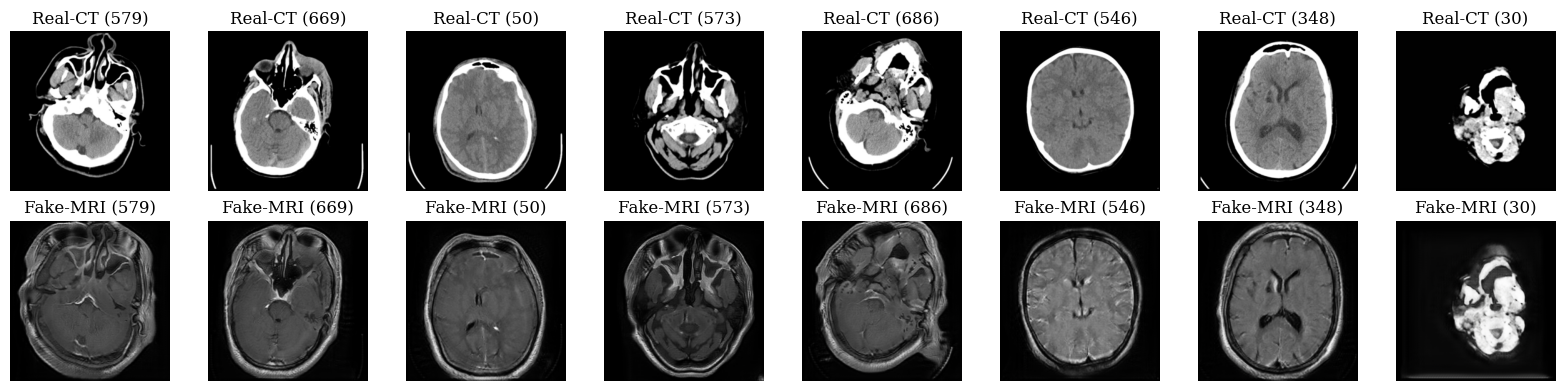

In [48]:
plot_test_samples()

Taking **MRI input images** from the source modality and translate it to **fake CT images** generated by the CycleGAN model:

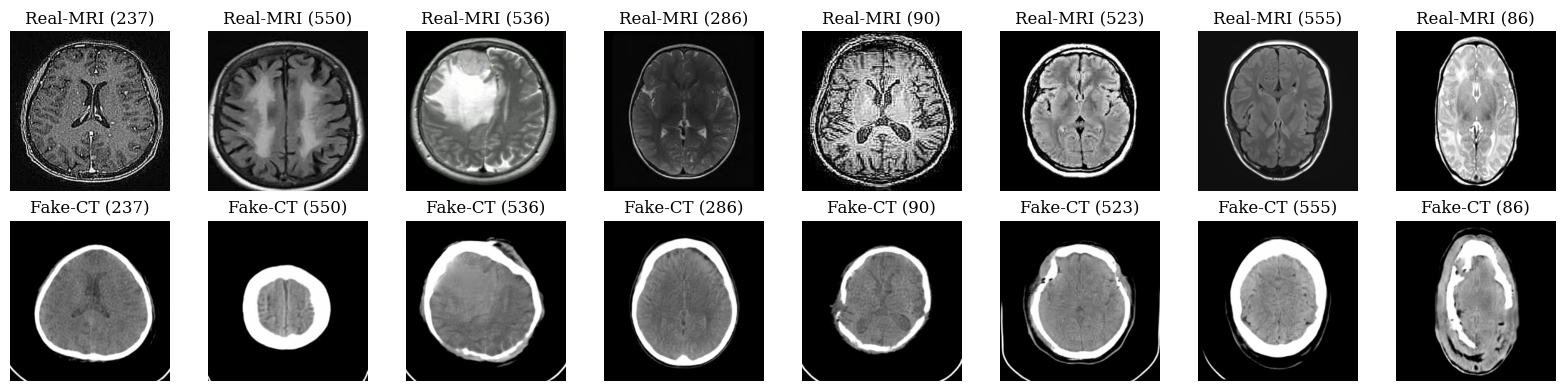

In [51]:
plot_test_samples()

### 🔁 Loading a Trained CycleGAN and Visualizing A → B → A Cycles

Initializes a pretrained **CycleGAN** model directly from the `pytorch-CycleGAN-and-pix2pix` framework and prepares it for inference on CT–MRI data. The test configuration is manually constructed using `TestOptions` to enable standalone model loading without running the full `test.py` pipeline.

Key steps in this cell:
- Loads the latest trained CycleGAN checkpoint and sets the model to evaluation mode.
- Extracts both generators:
  - **G_A**: translates from domain A → B (e.g., CT → MRI)
  - **G_B**: translates from domain B → A (e.g., MRI → CT)
- Defines preprocessing and inverse-normalization transforms consistent with CycleGAN training.

The `plot_org_fake_reconstructed_samples` function then:
- Randomly samples images from the chosen test split (`testA` or `testB`).
- Applies forward translation (A → B or B → A) followed by cycle reconstruction (A → B → A or B → A → B).
- Visualizes results in a **3-column layout**:
  1. Original input image  
  2. Translated (fake) image  
  3. Reconstructed image after the full cycle  

This provides a clear qualitative assessment of both **translation quality** and **cycle-consistency**, which are core properties of CycleGAN models.

In [ ]:
import glob
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from models import create_model
from options.test_options import TestOptions
import sys
import random

checkpoint_dir = "./workdir/checkpoints/brain_ct2mri"    
epoch = "latest"   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.argv = [
    "test",
    "--dataroot", ".",   
    "--name", "your_experiment_name",
    "--model", "cycle_gan",
    "--phase", "test"]
opt = TestOptions().parse()

opt.model = "cycle_gan"
opt.phase = "test"
opt.no_dropout = True
opt.serial_batches = True
opt.num_threads = 0
opt.batch_size = 1
opt.load_iter = 0
opt.epoch = epoch
opt.checkpoints_dir = os.path.dirname(checkpoint_dir)
opt.name = os.path.basename(checkpoint_dir)
opt.isTrain = False
opt.gpu_ids = [] if device.type == "cpu" else [0]
opt.device = torch.device("cuda:0" if (opt.gpu_ids and torch.cuda.is_available()) else "cpu")

model = create_model(opt)
model.setup(opt)
model.eval()

G_A = model.netG_A.to(device)
G_B = model.netG_B.to(device)

transform = transforms.Compose([ transforms.Resize((opt.load_size, opt.load_size)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
inv_transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2)),transforms.ToPILImage()])

In [42]:
def plot_org_fake_reconstructed_samples(dataset_base, test_name, sample_num):
    testset_dir = os.path.join(dataset_base, test_name)
    imgs_list = sorted(glob.glob(os.path.join(testset_dir, "*")))
    imgs_list = random.sample(imgs_list, k=min(sample_num, len(imgs_list)))

    fig, axes = plt.subplots(nrows=len(imgs_list), ncols=3, figsize=(6, 2 * len(imgs_list)))
    if len(imgs_list) == 1:
        axes = axes[None, :]  # keep indexing consistent
    for i, img_path in enumerate(imgs_list):
        img = Image.open(img_path).convert("RGB")

        if test_name == "testA":
            A = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                fake_B = G_A(A)
                rec_A = G_B(fake_B)
            fake_B_img = inv_transform(fake_B.squeeze().cpu())
            rec_A_img = inv_transform(rec_A.squeeze().cpu())

            fake_img, fake_label = fake_B_img, "MRI"
            rec_img, rec_label = rec_A_img, "CT"

        elif test_name == "testB":
            B = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                fake_A = G_B(B)
                rec_B = G_A(fake_A)
            fake_A_img = inv_transform(fake_A.squeeze().cpu())
            rec_B_img = inv_transform(rec_B.squeeze().cpu())

            fake_img, fake_label = fake_A_img, "CT"
            rec_img, rec_label = rec_B_img, "MRI"

        axes[i, 0].imshow(img)
        axes[i, 0].axis("off")
        axes[i, 1].imshow(fake_img)
        axes[i, 1].axis("off")
        axes[i, 2].imshow(rec_img)
        axes[i, 2].axis("off")
        if i==0:
            axes[i, 0].set_title(f"Original ({rec_label})", fontsize=10, fontweight="bold")
            axes[i, 1].set_title(f"Fake ({rec_label}→{fake_label})", fontsize=10, fontweight="bold")
            axes[i, 2].set_title(f"Rebuilt ({rec_label}→{fake_label}→{rec_label})", fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.show()

Take **CT input** from the source modality and translate it to **fake MRI** generated by the CycleGAN model and rebuild the **CT** from the **fake MRI** again.

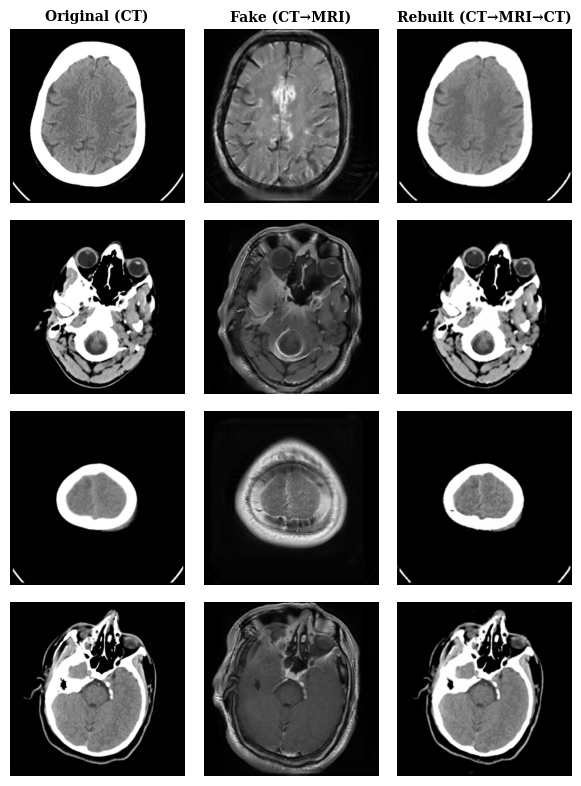

In [44]:
plot_org_fake_reconstructed_samples(dataset_base, test_name, sample_num)

Take **MRI input** from the source modality and translate it to **fake CT** generated by the CycleGAN model and rebuild the **MRI** from the **fake CT** again.

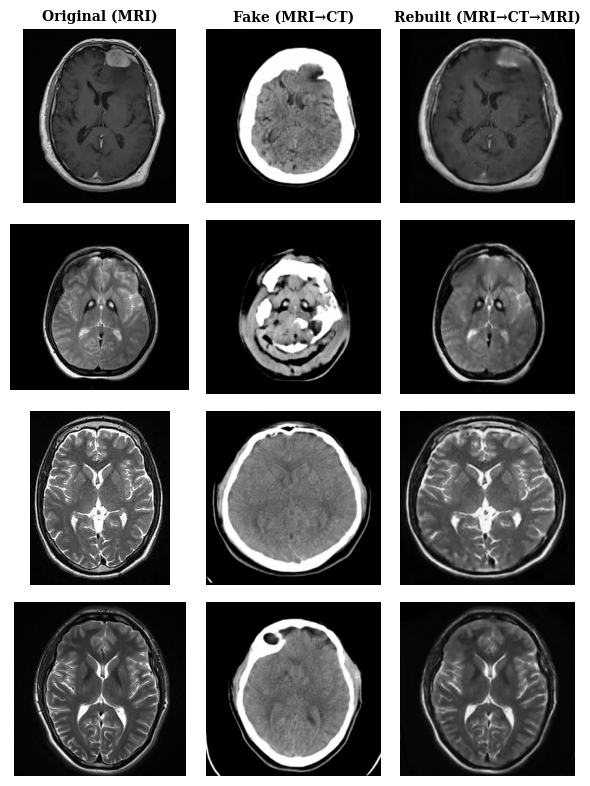

In [45]:
plot_org_fake_reconstructed_samples(dataset_base, test_name, sample_num)

---
© Ashkan M., NTNU  
Released under the MIT License
---